In [2]:
import os
import pandas as pd
import numpy as np
import sklearn
import nilearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

load labels

In [3]:
df_labels = pd.read_csv('./data/labels.csv')
df_labels

,seq,run1,run2,run3,run4
0,1,Cow,Engine,Street,Grass
1,2,Kitchen,Phone,Engine,Type
2,3,Grass,Sheep,Cow,Horn
3,4,Fry,Office,Phone,Fry
4,5,Sheep,Horn,Office,Office
5,6,Phone,Street,Fry,Kitchen
6,7,Engine,Cut,Cut,Sheep
7,8,Street,Kitchen,Sheep,Street
8,9,Horn,Fry,Grass,Engine
9,10,Office,Type,Horn,Phone


In [4]:
one_hot_enc = OneHotEncoder(handle_unknown='ignore')
one_hot_enc.fit_transform(df_labels.iloc[:, 1].to_numpy().reshape(-1, 1))

<12x12 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [5]:
cate_enc = LabelEncoder()
cate_enc.fit_transform(df_labels.iloc[:, 1].to_numpy())

array([ 0,  6,  4,  3,  9,  8,  2, 10,  5,  7,  1, 11])

load data

In [6]:

base_dir = './output/'
subjects = os.listdir(base_dir)
runs = [f'run{i}' for i in range(1, 5)]
WINDOW_SIZE = 19

print('subjects: ', subjects)
print('runs: ', runs)

subjects:  ['Sub017', 'Sub012', 'Sub009', 'Sub015', 'Sub016', 'Sub006', 'Sub023', 'Sub013', 'Sub004', 'Sub002', 'Sub014', 'Sub022', 'Sub003', 'Sub008', 'Sub024', 'Sub010', 'Sub020', 'Sub021', 'Sub011', 'Sub007', 'Sub005']
runs:  ['run1', 'run2', 'run3', 'run4']


In [7]:
from utils.util import ts_windowing

Xs = []
ys = []
for sub in subjects:
    for run in runs:
        ts = np.load(f'./output/{sub}/{run}/merged.npy')
        ts_windowed = ts_windowing(ts, WINDOW_SIZE)

        Xs.append(ts_windowed)
        ys.append(cate_enc.transform(df_labels.loc[:, run].to_numpy()))

In [8]:
sample_shape = Xs[0].shape
sample_shape

(12, 19, 164)

In [9]:
Xs = np.array(Xs).reshape(len(subjects)*len(runs)*sample_shape[0], sample_shape[1], sample_shape[2]).transpose(0, 2, 1)
ys = np.array(ys).reshape(len(subjects)*len(runs)*sample_shape[0])

In [10]:
print(Xs.shape)
print(ys.shape)

(1008, 164, 19)
(1008,)


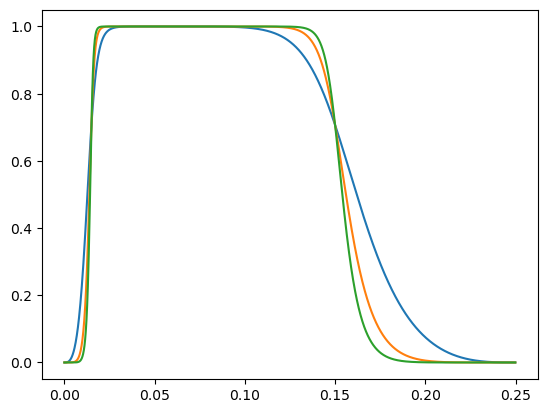

In [11]:
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz

lowcut = 0.015
highcut = 0.15
fs = 1/2

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, fs=fs, worN=2000)
    plt.plot(w, abs(h), label="order = %d" % order)

In [134]:
Xs.shape
sample = Xs[0, :, :]
filtered = butter_bandpass_filter(sample, 0.015, 0.1, 1/2)

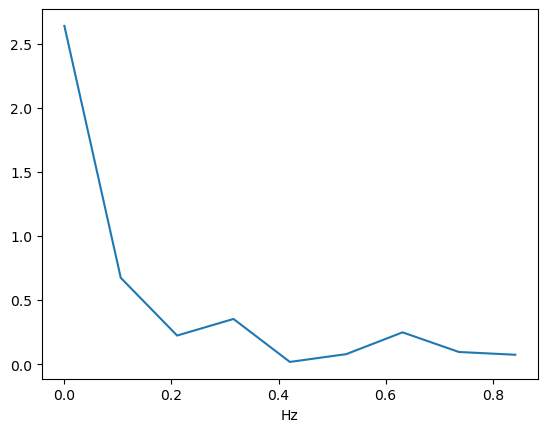

In [12]:
from utils.util import plot_freq
test_sample = Xs[0, 0, :]
test_sample.shape

plot_freq(test_sample, 2)

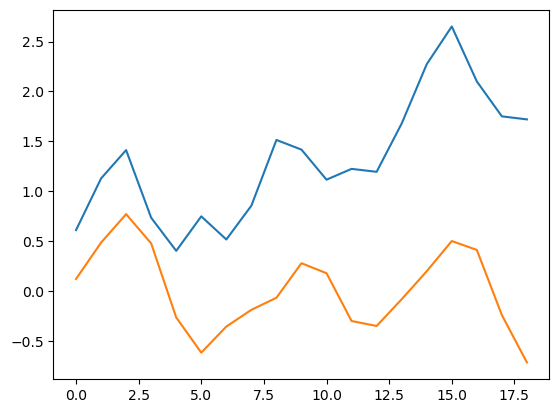

In [13]:
filtered = butter_bandpass_filter(test_sample, lowcut, highcut, fs, order=3)

plt.plot(test_sample)
plt.plot(filtered)

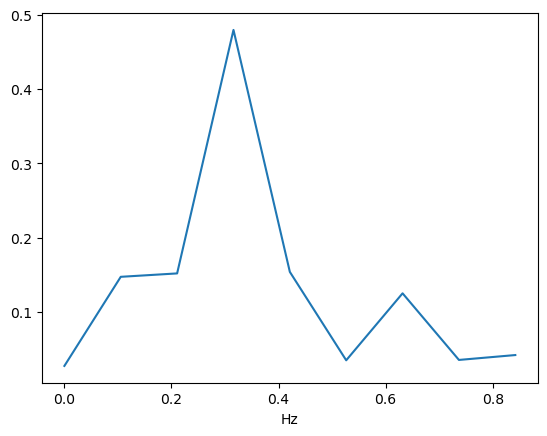

In [14]:
plot_freq(filtered, 2)

In [15]:
filtered = np.zeros_like(Xs)

for i in range(filtered.shape[0]):
    sample = Xs[i, :, :]
    filtered[i, :, :] = butter_bandpass_filter(sample, lowcut,highcut, fs)

### ROI analysis

In [16]:
classes_numeric = [i for i in range(len(cate_enc.classes_))]
classes_numeric

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [17]:
atlas_len = filtered.shape[1]
coefs = np.zeros((filtered.shape[0], atlas_len, atlas_len))
coefs.shape

for i in range(filtered.shape[0]):
    coefs[i, :, :] = np.corrcoef(filtered[i, :, :])


<AxesSubplot: >

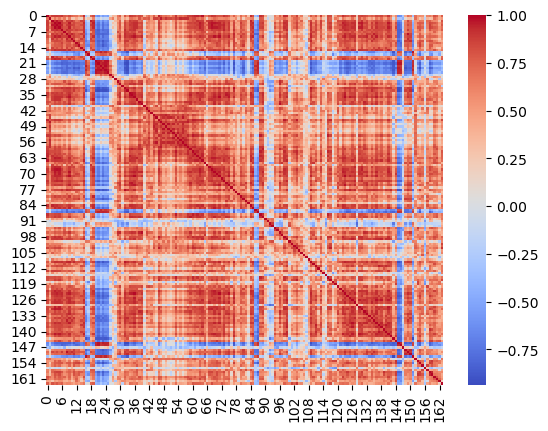

In [18]:
sns.heatmap(coefs[0, :, :], cmap='coolwarm')

In [19]:
coefs.shape
X_lasso = coefs.reshape(coefs.shape[0], -1)
X_lasso.shape

(1008, 26896)

### Lasso feature selection

#### fit

In [20]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

X_lasso = coefs.reshape(coefs.shape[0], -1)
y_lasso = ys

pipeline = Pipeline([
    ('model', Lasso())
])
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

search.fit(X_lasso, y_lasso)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ................model__alpha=0.1;, score=-11.305 total time=   0.4s
[CV 2/5] END ................model__alpha=0.1;, score=-11.311 total time=   0.3s
[CV 3/5] END ................model__alpha=0.1;, score=-11.615 total time=   0.4s
[CV 4/5] END ................model__alpha=0.1;, score=-11.365 total time=   0.4s
[CV 5/5] END ................model__alpha=0.1;, score=-11.300 total time=   0.4s
[CV 1/5] END ................model__alpha=0.2;, score=-11.735 total time=   0.2s
[CV 2/5] END ................model__alpha=0.2;, score=-11.943 total time=   0.2s
[CV 3/5] END ................model__alpha=0.2;, score=-12.031 total time=   0.3s
[CV 4/5] END ................model__alpha=0.2;, score=-11.841 total time=   0.2s
[CV 5/5] END ................model__alpha=0.2;, score=-11.932 total time=   0.2s
[CV 1/5] END model__alpha=0.30000000000000004;, score=-11.785 total time=   0.2s
[CV 2/5] END model__alpha=0.30000000000000004;,

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

#### select

In [21]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)


In [83]:
significant_conns = np.where(importance > 0)[0]

atlas_cares = significant_conns // atlas_len

X_selected = filtered[:, atlas_cares, :]
X_selected = X_selected.reshape(X_selected.shape[0], -1)

In [85]:
X_selected.shape

(1008, 665)

<AxesSubplot: >

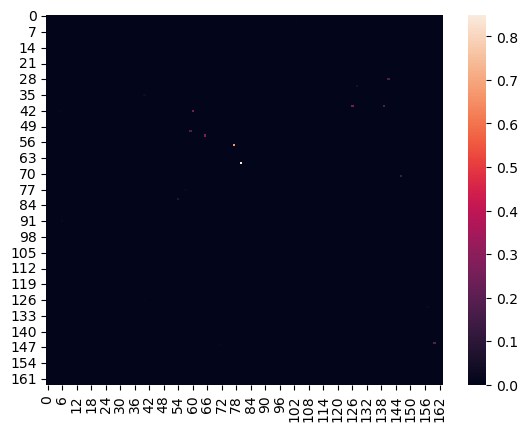

In [86]:
importance_m = importance.reshape(atlas_len, atlas_len)
sns.heatmap(importance_m)

#### predictive models

Models after feature selection

*Lasso*

In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, ys, test_size=0.1)

KNN

In [88]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [89]:
y_preds = knn.predict(X_test)

In [91]:
from sklearn.metrics import classification_report, accuracy_score

print(accuracy_score(y_test, y_preds))
print(classification_report(y_test, y_preds))

0.0891089108910891
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00         7
           2       0.07      0.29      0.11         7
           3       0.09      0.11      0.10         9
           4       0.06      0.11      0.08         9
           5       0.20      0.25      0.22         8
           6       0.17      0.10      0.12        10
           7       0.14      0.12      0.13         8
           8       0.00      0.00      0.00         7
           9       0.00      0.00      0.00        10
          10       0.50      0.10      0.17        10
          11       0.00      0.00      0.00         7

    accuracy                           0.09       101
   macro avg       0.10      0.09      0.08       101
weighted avg       0.11      0.09      0.08       101



/home/chan/miniconda3/envs/fmri/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chan/miniconda3/envs/fmri/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/chan/miniconda3/envs/fmri/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

X_train, X_test, y_train, y_test = train_test_split(X_selected, ys, test_size=0.1)

In [93]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)

SVC()

In [94]:
y_preds = model.predict(X_test)

print(accuracy_score(y_test, y_preds))
print(classification_report(y_test, y_preds))

0.21782178217821782
              precision    recall  f1-score   support

           0       0.33      0.38      0.35         8
           1       0.00      0.00      0.00        13
           2       0.12      0.29      0.17         7
           3       0.08      0.08      0.08        12
           4       0.38      0.38      0.38         8
           5       0.14      0.17      0.15         6
           6       0.45      0.50      0.48        10
           7       0.44      0.67      0.53         6
           8       0.20      0.38      0.26         8
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         6
          11       0.00      0.00      0.00         9

    accuracy                           0.22       101
   macro avg       0.18      0.24      0.20       101
weighted avg       0.17      0.22      0.19       101



Decision tree

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_selected, ys, test_size=0.1)

In [96]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [97]:
y_preds = model.predict(X_test)

print(accuracy_score(y_test, y_preds))
print(classification_report(y_test, y_preds))

0.22772277227722773
              precision    recall  f1-score   support

           0       0.27      0.38      0.32         8
           1       0.09      0.33      0.14         3
           2       0.00      0.00      0.00         5
           3       0.18      0.25      0.21         8
           4       0.22      0.29      0.25         7
           5       1.00      0.25      0.40        12
           6       0.44      0.29      0.35        14
           7       0.21      0.27      0.24        11
           8       0.22      0.20      0.21        10
           9       0.00      0.00      0.00         6
          10       0.20      0.40      0.27         5
          11       0.14      0.08      0.11        12

    accuracy                           0.23       101
   macro avg       0.25      0.23      0.21       101
weighted avg       0.31      0.23      0.23       101



PCA dimension reduction

Models before feature selection

In [103]:
from sklearn.model_selection import train_test_split

Xs_pure = filtered.reshape(filtered.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(Xs_pure, ys, test_size=0.1, stratify=ys)

In [104]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [105]:
y_preds = knn.predict(X_test)
print(accuracy_score(y_test, y_preds))
print(classification_report(y_test, y_preds))

0.10891089108910891
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.08      0.11      0.09         9
           2       0.11      0.25      0.15         8
           3       0.26      0.56      0.36         9
           4       0.00      0.00      0.00         8
           5       0.10      0.11      0.11         9
           6       0.17      0.12      0.14         8
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         9
           9       0.00      0.00      0.00         8
          10       0.17      0.12      0.14         8
          11       0.00      0.00      0.00         8

    accuracy                           0.11       101
   macro avg       0.07      0.11      0.08       101
weighted avg       0.07      0.11      0.08       101



SVC

In [106]:
from sklearn.model_selection import train_test_split

# Xs_pure = .reshape(Xs.shape[0], -1)
Xs_pure = filtered.reshape(filtered.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(Xs_pure, ys, test_size=0.1, stratify=ys)

In [107]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)

SVC()

In [108]:
y_preds = model.predict(X_test)

print(accuracy_score(y_test, y_preds))
print(classification_report(y_test, y_preds))

0.15841584158415842
              precision    recall  f1-score   support

           0       1.00      0.11      0.20         9
           1       0.00      0.00      0.00         9
           2       0.27      0.38      0.32         8
           3       0.07      0.12      0.09         8
           4       0.17      0.11      0.13         9
           5       0.07      0.12      0.09         8
           6       0.30      0.38      0.33         8
           7       0.20      0.38      0.26         8
           8       0.14      0.11      0.12         9
           9       0.14      0.11      0.12         9
          10       0.00      0.00      0.00         8
          11       0.08      0.12      0.10         8

    accuracy                           0.16       101
   macro avg       0.20      0.16      0.15       101
weighted avg       0.21      0.16      0.15       101



Decision tree

In [111]:
from sklearn.model_selection import train_test_split

Xs_pure = filtered.reshape(filtered.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(Xs_pure, ys, test_size=0.1, stratify=ys)

In [112]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [113]:
y_preds = model.predict(X_test)

print(accuracy_score(y_test, y_preds))
print(classification_report(y_test, y_preds))

0.21782178217821782
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.20      0.22      0.21         9
           2       0.14      0.12      0.13         8
           3       0.18      0.25      0.21         8
           4       0.30      0.33      0.32         9
           5       0.10      0.12      0.11         8
           6       0.20      0.11      0.14         9
           7       0.22      0.22      0.22         9
           8       0.25      0.33      0.29         9
           9       0.17      0.12      0.14         8
          10       0.40      0.50      0.44         8
          11       0.33      0.25      0.29         8

    accuracy                           0.22       101
   macro avg       0.21      0.22      0.21       101
weighted avg       0.21      0.22      0.21       101



#### After filtering

##### SVC

In [114]:
from sklearn.model_selection import train_test_split

Xs_pure = filtered.reshape(filtered.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(Xs_pure, ys, test_size=0.1, stratify=ys)

In [115]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)

SVC()

In [116]:
y_preds = model.predict(X_test)

print(accuracy_score(y_test, y_preds))
print(classification_report(y_test, y_preds))

0.2376237623762376
              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.25      0.25      0.25         8
           2       0.31      0.44      0.36         9
           3       0.10      0.12      0.11         8
           4       0.33      0.33      0.33         9
           5       0.25      0.22      0.24         9
           6       0.20      0.12      0.15         8
           7       0.21      0.33      0.26         9
           8       0.17      0.25      0.20         8
           9       0.12      0.11      0.12         9
          10       0.17      0.12      0.14         8
          11       0.50      0.25      0.33         8

    accuracy                           0.24       101
   macro avg       0.26      0.23      0.24       101
weighted avg       0.26      0.24      0.24       101



### PCA 

#### Before filtering

In [121]:
from sklearn.decomposition import PCA

X_pca_bf_filtering = Xs.reshape(Xs.shape[0], -1)
X_pca_bf_filtering.shape

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca_bf_filtering, ys, test_size=0.1, stratify=ys)

pca = PCA(n_components=40)
pca.fit(X_train)

PCA(n_components=40)

In [124]:
X_train = pca.transform(X_train_pca)
y_train = y_train_pca
X_test = pca.transform(X_test_pca)
y_test = y_test_pca

#### SVC

In [125]:
from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)

SVC()

In [126]:
y_preds = model.predict(X_test)

print(accuracy_score(y_test, y_preds))
print(classification_report(y_test, y_preds))

0.3069306930693069
              precision    recall  f1-score   support

           0       0.40      0.25      0.31         8
           1       0.33      0.62      0.43         8
           2       0.40      0.50      0.44         8
           3       0.45      0.62      0.53         8
           4       0.33      0.33      0.33         9
           5       0.00      0.00      0.00         9
           6       0.29      0.22      0.25         9
           7       0.45      0.56      0.50         9
           8       0.20      0.12      0.15         8
           9       0.09      0.12      0.11         8
          10       0.14      0.11      0.12         9
          11       0.33      0.25      0.29         8

    accuracy                           0.31       101
   macro avg       0.29      0.31      0.29       101
weighted avg       0.28      0.31      0.29       101



#### After filtering


In [131]:
from sklearn.decomposition import PCA

X_pca_af_filtering = filtered.reshape(filtered.shape[0], -1)
X_pca_af_filtering.shape

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca_af_filtering, ys, test_size=0.1, stratify=ys)

pca = PCA(n_components=40)
pca.fit(X_train)

PCA(n_components=40)